In [ ]:

import re
import sys
import os
import random
import string
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from tensorflow.keras.layers import add
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, Concatenate, Lambda, RepeatVector
import glob
import pandas as pd
np.random.seed(1)


In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

os.chdir("/content/drive/Othercomputers/Dell")

Mounted at /content/drive


In [ ]:
!pip install keras-tcn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 37.7 MB/s 


In [ ]:
from tcn import TCN

In [ ]:
os.chdir("/content/drive/Othercomputers/Dell")
!pwd

/content/drive/Othercomputers/Dell


In [ ]:
path = !pwd
path
#path = /content/drive/Othercomputers/Dell/Action-Segmentation-Project

['/content/drive/Othercomputers/Dell']

In [ ]:
#get all the optofoce_data.csv

# files = ['/media/sf_Action-Segmentation-Project/avocado','']
# for file in files:
#     for name in glob.glob(f"{file}/clutter/[0-9]*/optoforce_data.csv"):
#         print(name)

# files = glob.glob(f"/media/sf_Action-Segmentation-Project/avocado/clutter/[0-9]*/optoforce_data.csv")
files = glob.glob(f"/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/[0-9]*/optoforce_data.csv")
files

['/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/7/optoforce_data.csv',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/4/optoforce_data.csv',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/5/optoforce_data.csv',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/9/optoforce_data.csv',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/8/optoforce_data.csv',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/2/optoforce_data.csv',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/3/optoforce_data.csv',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/10/optoforce_data.csv',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/6/optoforce_da

In [ ]:
#labels = glob.glob(f"/media/sf_Action-Segmentation-Project/avocado/clutter/[0-9]*/labels")
labels = glob.glob(f"/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/[0-9]*/labels")

labels

['/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/7/labels',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/4/labels',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/5/labels',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/9/labels',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/8/labels',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/2/labels',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/3/labels',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/10/labels',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/6/labels',
 '/content/drive/Othercomputers/Dell/Action-Segmentation-Project/dataset/avocado/clutter/1/labels']

In [ ]:
frames = []
data = []
for f in files:
    data_df = pd.read_csv(f)
    data_df = data_df.iloc[::100,:]
    data_df["label"] = ""
    frames.append(data_df)



In [ ]:
action_segment_td = []
ground_truth_actions = []

for l in labels:
    td_per_file = []
    gt_actions_per_file = []
    with open (l) as f:
        for line in f:
            x, y  = line.split(';')
            #start_time, end_time = x.split(':')
            td_per_file.append(x)
            gt_actions_per_file.append(y.strip('\n'))
        action_segment_td.append(td_per_file)
        ground_truth_actions.append(gt_actions_per_file)


In [ ]:
action_segment_td #timestmps

[['1635185484881988107:1635185508960098923',
  '1635185508960098923:1635185540489498512',
  '1635185540489498512:1635185544057936064',
  '1635185544057936064:1635185549350041664',
  '1635185549350041664:1635185554816474229',
  '1635185554816474229:1635185560655390372'],
 ['1634917079582315741:1634917108946914859',
  '1634917108946914859:1634917129420464685',
  '1634917129420464685:1634917131539426547',
  '1634917131539426547:1634917134957114204',
  '1634917134957114204:1634917140855676126',
  '1634917140855676126:1634917153391803434'],
 ['1634918557303008582:1634918568217991596',
  '1634918568217991596:1634918593817386818',
  '1634918593817386818:1634918646595079287',
  '1634918646595079287:1634918651382668779',
  '1634918651382668779:1634918657623002640',
  '1634918657623002640:1634918664418463962'],
 ['1635186448159756509:1635186459390779330',
  '1635186459390779330:1635186464698664958',
  '1635186464698664958:1635186467998475334',
  '1635186467998475334:1635186475265396949',
  '1635

In [ ]:
len(ground_truth_actions) #labels


10

In [ ]:
ground_truth_actions


[['move-in', 'manipulate', 'grasp', 'pick-up', 'move-out', 'drop'],
 ['move-in', 'manipulate', 'grasp', 'pick-up', 'move-out', 'drop'],
 ['move-in', 'manipulate', 'grasp', 'pick-up', 'move-out', 'drop'],
 ['move-in', 'manipulate', 'move-in', 'grasp', 'pick-up', 'move-out', 'drop'],
 ['move-in',
  'manipulate',
  'move-out',
  'move-in',
  'manipulate',
  'grasp',
  'pick-up',
  'move-out',
  'drop'],
 ['move-in', 'manipulate', 'grasp', 'pick-up', 'move-out', 'drop'],
 ['move-in',
  'manipulate',
  'move-out',
  'move-in',
  'manipulate',
  'move-out',
  'move-in',
  'grasp',
  'pick-up',
  'move-out',
  'drop'],
 ['move-in',
  'manipulate',
  'move-out',
  'move-in',
  'grasp',
  'pick-up',
  'move-out',
  'drop'],
 ['move-in',
  'manipulate',
  'move-out',
  'move-in',
  'manipulate',
  'move-out',
  'move-in',
  'grasp',
  'pick-up',
  'move-out',
  'drop'],
 ['move-in',
  'manipulate',
  'move-out',
  'move-in',
  'manipulate',
  'grasp',
  'pick-up',
  'move-out',
  'drop']]

In [ ]:
for df, duration_of_actions, labels in zip(frames,action_segment_td, ground_truth_actions):
    condition = []
    for actions in duration_of_actions:
        start_time, end_time = actions.split(':')
        condition.append(df['time'].between(int(start_time),int(end_time)))

    df['label'] = np.select(condition,labels,default=None)
    df.dropna(inplace=True)


In [ ]:
features = ['index_x', 'index_y', 'index_z','middle_x','middle_y','middle_z','ring_x','ring_y','ring_z','thumb_x', 'thumb_y', 'thumb_z' ]
for frame in frames:
  for feature in frame[features]:
    mean = frame[feature].mean()
    std = frame[feature].std()

    frame[feature] = (frame[feature] - mean)/std


In [ ]:
len(frames[0])


630

In [ ]:
frames[0]

,time,index_x,index_y,index_z,middle_x,middle_y,middle_z,ring_x,ring_y,ring_z,thumb_x,thumb_y,thumb_z,label
6500,1635185484922953472,0.201953,0.275375,0.344244,0.094861,-0.187936,-0.068777,0.255695,-0.109842,1.241198,0.139089,0.406214,0.299356,move-in
6600,1635185485043865088,0.209984,0.275375,0.344244,0.090973,-0.170473,-0.068777,0.255695,1.445226,1.241198,0.116032,0.398856,0.299356,move-in
6700,1635185485165968384,0.193923,0.268388,0.344244,0.079307,-0.222862,-0.068777,0.255695,-0.887376,0.595221,0.131403,0.391497,0.293194,move-in
6800,1635185485295324672,0.213999,0.282361,0.347977,0.090973,-0.170473,-0.068777,0.835149,-0.109842,1.241198,0.116032,0.406214,0.299356,move-in
6900,1635185485415177216,0.218014,0.296334,0.351709,0.094861,-0.170473,-0.068777,3.152962,1.445226,1.564186,0.146775,0.413573,0.299356,move-in
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69000,1635185560152794112,0.177862,0.191538,0.340512,0.141524,0.039084,-0.457297,-1.482665,0.667692,0.595221,0.623297,0.619612,0.385618,drop
69100,1635185560274807552,0.250136,0.526885,0.232267,0.456494,-0.903921,0.430750,-0.323758,-0.109842,0.595221,1.745430,1.215653,0.693698,drop
69200,1635185560394919424,0.205969,0.233456,0.321849,0.114304,-0.135547,-0.087278,0.255695,-1.664911,0.918209,0.277434,0.376780,0.262386,drop
69300,1635185560508478208,0.189908,0.226470,0.329314,0.114304,-0.187936,-0.087278,-0.323758,-2.442445,0.595221,0.162147,0.369422,0.262386,drop


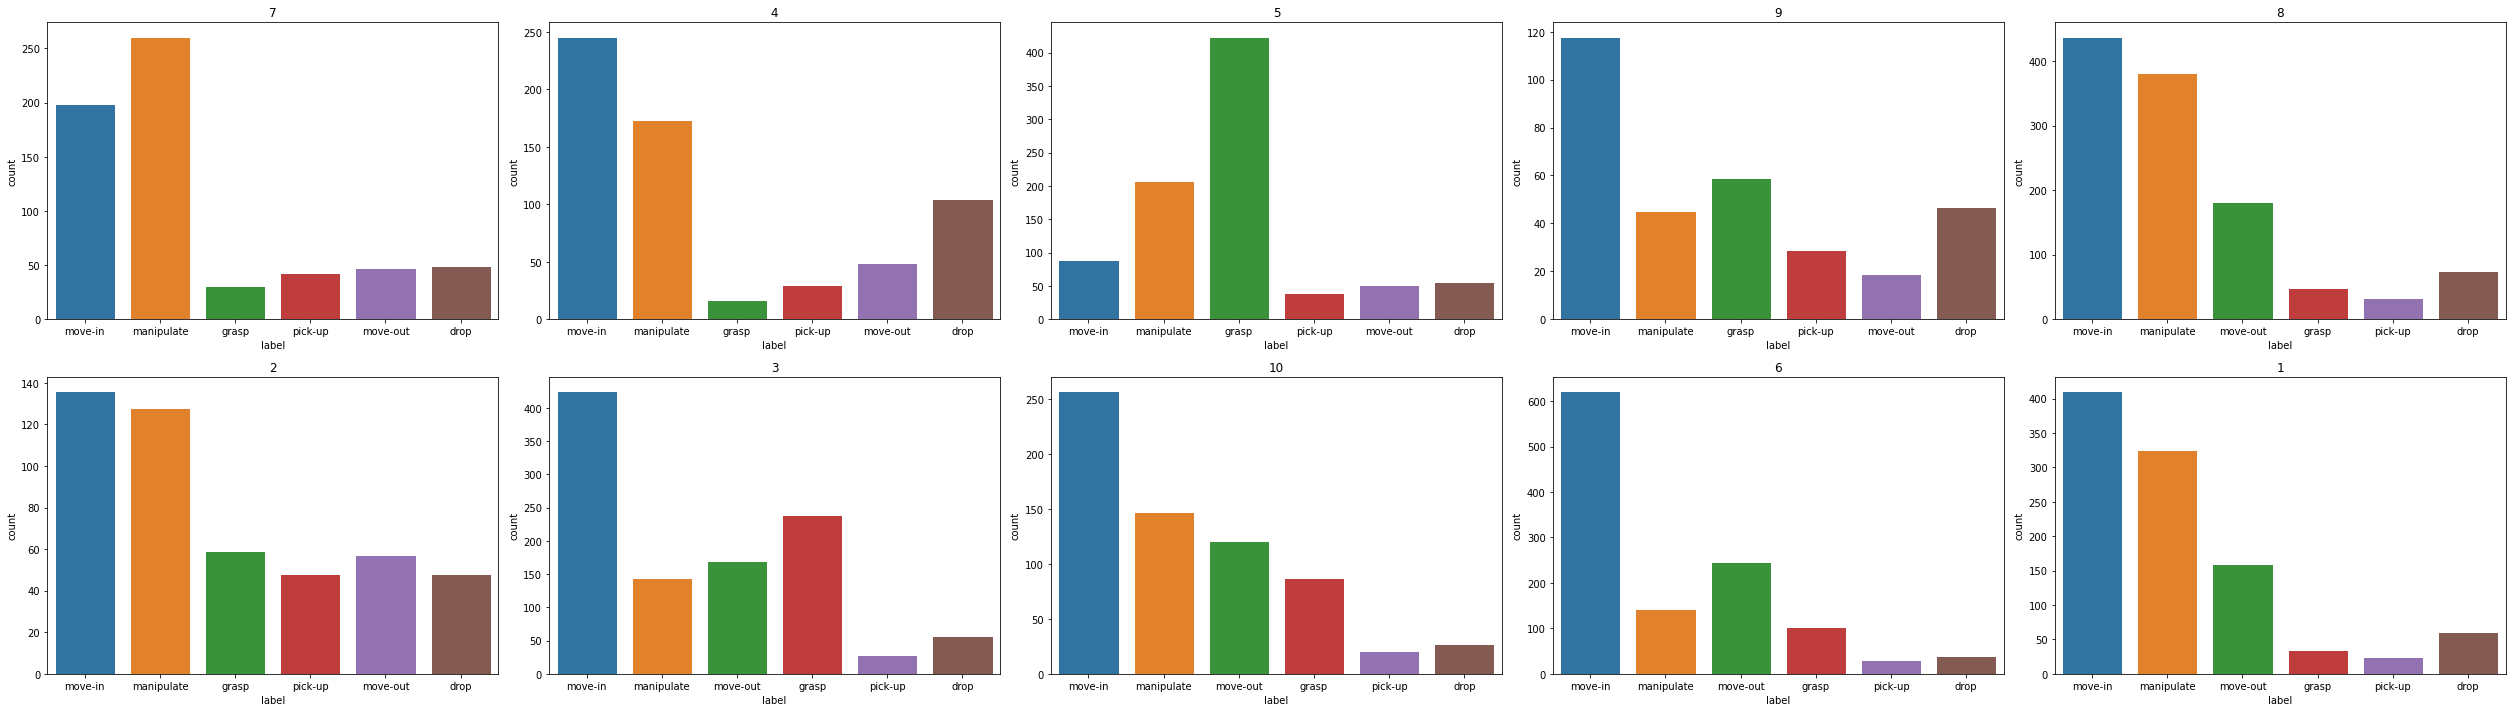

In [ ]:
import seaborn as sns
fig, ax = plt.subplots(2,5, figsize=(35,10))
sns.set_style('whitegrid')
plt.title('Number of samples by activity')
index = -1
for i in range(2):
  for j in range(5):
    index +=1
    sns.countplot(x = 'label', data = frames[index],ax=ax[i][j])
    ax[i][j].set_title(int(re.search(r'\d+', files[index]).group()))
plt.tight_layout() 
plt.show()

In [ ]:
unique_actions = set()

for frame in frames:
    for label in frame['label']:
        unique_actions.add(label)


In [ ]:
unique_actions


{'drop', 'grasp', 'manipulate', 'move-in', 'move-out', 'pick-up'}

In [ ]:
one_hot_encoding_acts = pd.get_dummies(list(unique_actions))
one_hot_encoding_acts

,drop,grasp,manipulate,move-in,move-out,pick-up
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,1,0
3,0,0,0,0,0,1
4,0,0,1,0,0,0
5,0,0,0,1,0,0


In [ ]:
index_label_map = {np.argmax(v):k for k, v in one_hot_encoding_acts.items()}
index_label_map

{0: 'drop',
 1: 'grasp',
 2: 'move-out',
 3: 'pick-up',
 4: 'manipulate',
 5: 'move-in'}

In [ ]:
actions_per_seq = []
for frame in frames:
    action_encodings = []
    for i in range(0, len(frame)):
        action_encodings.append(one_hot_encoding_acts[frame['label'].iloc[i]])
    actions_per_seq.append(action_encodings)

In [ ]:
len(actions_per_seq)


10

In [ ]:
len(actions_per_seq[0])


630

In [ ]:
frames[0].columns

Index(['time', 'index_x', 'index_y', 'index_z', 'middle_x', 'middle_y',
       'middle_z', 'ring_x', 'ring_y', 'ring_z', 'thumb_x', 'thumb_y',
       'thumb_z', 'label'],
      dtype='object')

In [ ]:
features = ['index_x', 'index_y', 'index_z','middle_x','middle_y','middle_z','ring_x','ring_y','ring_z','thumb_x', 'thumb_y', 'thumb_z' ]
numeric_features = frames[0][features]
#numeric_features.head()
np.array(numeric_features)

array([[0.20195339, 0.27537479, 0.34424433, ..., 0.1390893 , 0.40621444,
        0.29935586],
       [0.20998385, 0.27537479, 0.34424433, ..., 0.11603178, 0.3988559 ,
        0.29935586],
       [0.19392293, 0.2683884 , 0.34424433, ..., 0.13140346, 0.39149737,
        0.29319426],
       ...,
       [0.20596862, 0.23345643, 0.32184886, ..., 0.27743441, 0.3767803 ,
        0.26238627],
       [0.1899077 , 0.22647004, 0.32931402, ..., 0.16214682, 0.36942177,
        0.26238627],
       [0.19392293, 0.25441561, 0.32931402, ..., 0.13140346, 0.36942177,
        0.25622467]])

In [ ]:
numeric_features.head()


,index_x,index_y,index_z,middle_x,middle_y,middle_z,ring_x,ring_y,ring_z,thumb_x,thumb_y,thumb_z
6500,0.201953,0.275375,0.344244,0.094861,-0.187936,-0.068777,0.255695,-0.109842,1.241198,0.139089,0.406214,0.299356
6600,0.209984,0.275375,0.344244,0.090973,-0.170473,-0.068777,0.255695,1.445226,1.241198,0.116032,0.398856,0.299356
6700,0.193923,0.268388,0.344244,0.079307,-0.222862,-0.068777,0.255695,-0.887376,0.595221,0.131403,0.391497,0.293194
6800,0.213999,0.282361,0.347977,0.090973,-0.170473,-0.068777,0.835149,-0.109842,1.241198,0.116032,0.406214,0.299356
6900,0.218014,0.296334,0.351709,0.094861,-0.170473,-0.068777,3.152962,1.445226,1.564186,0.146775,0.413573,0.299356


In [ ]:
numeric_features_per_seq = [np.array(frames[i][features]) for i in range(len(frames))]

In [ ]:
labels_per_seq =   [np.array(actions_per_seq[i]) for i in range(len(actions_per_seq))]

In [ ]:
labels_per_seq[0].shape[0]

630

In [ ]:
def CausalWindowGenerator(sequence, labels, window_length=250, stride =1, n_th_frame = 1):
  """
  squence = todo

  """
  sequence_len = len(sequence)
  for t in range(0,sequence_len,stride):
    if t >= window_length-1:
      start_index = t-window_length+1
      x = sequence[start_index:t+1:n_th_frame,:]
      y = labels[start_index:t+1:n_th_frame,:]
    else:
      padding_x = np.tile(sequence[0], ((window_length-t-1),1))
      x = sequence[0:t+1:n_th_frame, :]
      x = np.concatenate((padding_x,x),axis = 0)
      
      padding_y =  np.tile(labels[0], ((window_length-t-1),1))
      y = labels[0:t+1:n_th_frame, :]
      y = np.concatenate((padding_y,y),axis = 0)
  
    yield x, y

In [ ]:
# test_for_multiple_seq = np.random.rand(2,5,12)
# test_for_multiple_seq
test_for_multiple_seq = [numeric_features_per_seq[0]]
len(test_for_multiple_seq)

1

In [ ]:
# test_labels_for_multiple_seq = labels_per_seq[0][np.random.choice(np.arange(labels_per_seq[0].shape[0]), size = (2,5,))]
# test_labels_for_multiple_seq

test_labels_for_multiple_seq = [labels_per_seq[0]]
len(test_labels_for_multiple_seq)


1

In [ ]:
X_train = []
y_train = []
for x,y in zip(numeric_features_per_seq,labels_per_seq):
    feature_windows_per_seq = []
    label_windows_per_seq = []
    for a, b in CausalWindowGenerator(x,y): #for each timestep create a window 
      # print(a)
      # print(b)
      feature_windows_per_seq.append(a)
      label_windows_per_seq.append(b)
      #break
    X_train.append(feature_windows_per_seq)
    y_train.append(label_windows_per_seq)

    #break
    #print("----------")
    #X_train.append(temp))
    
#X_train

In [ ]:
# X_train = np.concatenate(X_train, axis = 0)
# print(X_train.shape)
# y_train = np.concatenate(y_train, axis = 0)
# print(y_train.shape)

In [ ]:
# y_train[0][0]

In [ ]:
# from collections import Counter 

# counts = []

# for window in range(500,630):
#   for timestep in range(len(y_train[window])): 
#     counts.append(index_label_map[np.argmax(y_train[window][timestep])])


# counts_dict = Counter(counts)

In [ ]:
len(y_train)

10

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X_train,y_train,shuffle=True, stratify=None, test_size=0.2)

In [ ]:
print(len(X_train))
# print(X_train[0].shape) 
# print(y_train[0].shape)

print('-------')

print(len(X_test))
# print(X_test[0].shape) 
# print(y_test[0].shape)


8
-------
2


In [ ]:
X_train, X_val, y_train, y_val  = train_test_split(X_train,y_train,shuffle=True, stratify=None, test_size=0.2)

In [ ]:
print(len(X_train))
#print(X_train[0].shape)
#print(y_train[0].shape)

print('-------')

print(len(X_val))
#print(X_val[0].shape)
#print(y_val[0].shape)


6
-------
2


In [ ]:
X_train = np.concatenate(X_train,axis = 0)
print(X_train.shape)
y_train = np.concatenate(y_train,axis = 0)
print(y_train.shape)
print("----------------")
X_val = np.concatenate(X_val,axis = 0)
print(X_val.shape)
y_val = np.concatenate(y_val,axis = 0)
print(y_val.shape)

print("------------------")

X_test = np.concatenate(X_test,axis = 0)
print(X_test.shape)
y_test = np.concatenate(y_test,axis = 0)
print(y_test.shape)

(4606, 250, 12)
(4606, 250, 6)
----------------
(1501, 250, 12)
(1501, 250, 6)
------------------
(1884, 250, 12)
(1884, 250, 6)


In [ ]:
# longest_seq = 0
# for seq in frames:
#   print(seq.shape[0])

#   if seq.shape[0] >= longest_seq:
#     longest_seq = seq.shape[0]

# longest_seq


In [ ]:

class StackedTCN(tf.keras.Model):
  def __init__(self, num_units= 100, N_TIME_STEPS = 250, N_FEATURES = 12):
    super().__init__()
    self.inputs = Input(shape = (250,12),dtype = 'float64' )
    self.tcn1 = TCN()
    self.rv = RepeatVector(N_TIME_STEPS)

    self.tcn2 = TCN(return_sequences = True)

    self.time_distribited = TimeDistributed(Dense(units = 6,activation = 'softmax'))

  def call(self, inputs):
    #x = self.inputs(inputs)
    x = self.tcn1(inputs)
    x = self.rv(x)
    x = self.tcn2(x)
    x = self.time_distribited(x)

    return x

  def summary(self):
    x = self.inputs
    return Model(inputs = x, outputs = self.call(x)).summary()


In [ ]:
model1 = StackedTCN()
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 12)]         0         
                                                                 
 tcn (TCN)                   (None, 64)                139072    
                                                                 
 repeat_vector (RepeatVector  (None, 250, 64)          0         
 )                                                               
                                                                 
 tcn_1 (TCN)                 (None, 250, 64)           148224    
                                                                 
 time_distributed (TimeDistr  (None, 250, 6)           390       
 ibuted)                                                         
                                                                 
Total params: 287,686
Trainable params: 287,686
Non-trainable

In [ ]:
mode1_history = model1.fit(x = X_train, y = y_train,
                           batch_size = 64,
                           epochs = 20,
                           validation_data = (X_val, y_val), 
                           verbose = 1)

Epoch 1/20
72/72 [==============================] - 23s 89ms/step - loss: 11.9134 - accuracy: 0.2608 - val_loss: 14.1990 - val_accuracy: 0.1191
Epoch 2/20
72/72 [==============================] - 3s 45ms/step - loss: 11.8820 - accuracy: 0.2628 - val_loss: 14.1990 - val_accuracy: 0.1191
Epoch 3/20
72/72 [==============================] - 3s 45ms/step - loss: 11.8820 - accuracy: 0.2628 - val_loss: 14.1990 - val_accuracy: 0.1191
Epoch 4/20
72/72 [==============================] - 3s 45ms/step - loss: 11.8820 - accuracy: 0.2628 - val_loss: 14.1990 - val_accuracy: 0.1191
Epoch 5/20
72/72 [==============================] - 3s 45ms/step - loss: 11.8820 - accuracy: 0.2628 - val_loss: 14.1990 - val_accuracy: 0.1191
Epoch 6/20
31/72 [===========>..................] - ETA: 1s - loss: 11.9581 - accuracy: 0.2581

KeyboardInterrupt: ignored

In [ ]:
results = model1.evaluate(X_test,y_test)
print(results)

59/59 [==============================] - 1s 15ms/step - loss: 3.5559 - accuracy: 0.3678
[3.555941104888916, 0.3678131699562073]
